In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
%cd /content/drive/MyDrive/NEXCO/src/EDA/

Mounted at /content/drive
/content/drive/MyDrive/NEXCO/src/EDA


In [ ]:
!pip install japanize_matplotlib jpholiday

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 22.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=9f29367dde1fc172e792386157cc3002eb028ca2e81cc1e404844264d0d419db
  Stored in directory: /root/.cache/pip/wheels/4f/ca/96/4cc5e192421cceb077fbf4ffec533382edd416fd3fa0af0bbd
Successfully built japanize_matplotlib


In [ ]:
# ========================================
# Library
# ========================================
import os
import math
import random
import pickle
import itertools
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import jpholiday
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import (
    TimeSeriesSplit,
    StratifiedKFold,
    KFold,
    GroupKFold,
    StratifiedGroupKFold
)# StratifiedGroupKFold, 
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from scipy.optimize import minimize
import lightgbm as lgb

pd.set_option('display.max_columns', None)

def set_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
set_seed()

In [ ]:
train_df = pd.read_csv("../train/train.csv")
search_spec_df = pd.read_csv("../train/search_data.csv")
search_unspec_df = pd.read_csv("../train/search_unspec_data.csv")
road_df = pd.read_csv("../train/road.csv")

In [ ]:
train_df.shape

(910080, 7)

In [ ]:
train_df.head(5)# (910080, 7)

,datetime,start_code,end_code,OCC,allCars,speed,is_congestion
0,2021-04-08 00:00:00,1110210,1800006,2.083333,510,80.712329,0
1,2021-04-08 01:00:00,1110210,1800006,1.500000,433,81.730415,0
2,2021-04-08 02:00:00,1110210,1800006,1.333333,366,81.288828,0
3,2021-04-08 03:00:00,1110210,1800006,1.500000,426,82.953162,0
4,2021-04-08 04:00:00,1110210,1800006,1.833333,498,82.430862,0


In [ ]:
search_spec_df.shape

(910080, 4)

In [ ]:
search_spec_df.head(5)# (910080, 4)

,datetime,start_code,end_code,search_1h
0,2021-04-08 00:00:00,1110210,1800006,15.0
1,2021-04-08 01:00:00,1110210,1800006,6.0
2,2021-04-08 02:00:00,1110210,1800006,3.0
3,2021-04-08 03:00:00,1110210,1800006,26.0
4,2021-04-08 04:00:00,1110210,1800006,31.0


In [ ]:
search_unspec_df.shape

(37920, 4)

In [ ]:
search_unspec_df.head(5)# (37920, 4)

,date,start_code,end_code,search_unspec_1d
0,2021-04-08,1110210,1800006,3448.0
1,2021-04-09,1110210,1800006,2992.0
2,2021-04-10,1110210,1800006,2970.0
3,2021-04-11,1110210,1800006,2992.0
4,2021-04-12,1110210,1800006,2974.0


In [ ]:
road_df.shape

(79, 18)

In [ ]:
road_df.head(5)# (79, 18)

,start_name,end_name,start_code,end_code,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,end_lng,start_degree,end_degree,KP,direction,start_KP,end_KP,limit_speed,road_code
0,大泉ＪＣＴ,所沢,1110210,1800006,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3.90,下り,0.0,9.4,100,1800
1,京葉道路・館山自動車道接続部,市原,1130001,1130006,12,12,35.55136,35.49471,140.143014,140.094986,2.0,2.0,39.17,下り,35.7,43.7,100,1130
2,市原,京葉道路・館山自動車道接続部,1130006,1130001,12,12,35.49471,35.55136,140.094986,140.143014,2.0,2.0,39.17,上り,43.7,35.7,100,1130
3,市原,姉崎袖ヶ浦,1130006,1130016,12,12,35.49471,35.42603,140.094986,140.045153,2.0,2.0,46.27,下り,43.7,53.7,100,1130
4,姉崎袖ヶ浦,市原,1130016,1130006,12,12,35.42603,35.49471,140.045153,140.094986,2.0,2.0,46.27,上り,53.7,43.7,100,1130


In [ ]:
'''
train                     :    (910080, 7) << 時間(24h*37920d), sid, eid, 車線占有率, 通過台数, スピード平均, 目的変数(渋滞orNot)
search                 :     (910080, 4) << 時間(24h*37920d), sid, eid, 検索数
search_unspec   :    (37920, 4)    << 日付(37920d)         , sid, eid, 検索数
road                     :    (79, 18)         <<  sid, s名, s県id, s緯度, s経度, s接続IC数, sKP
                                                                eid, e名, e県id, e緯度, e経度, e接続IC数, eKP
                                                                上りor下り, TKP, 制限速度, 道路コード(関越道:1800、館山道:1130)
                                                                
                                    KP<起点からの距離(関越道起点は大泉JCT（練馬IC）、館山道起点は篠崎IC（京葉道路)
train_df, search_df, search_unspec_df, road_df

train < 時間 > search
train < 日付 > search_unspec
train < sid, eid > road

all_df >> 15+18
'''

'\ntrain                     :    (910080, 7) << 時間(24h*37920d), sid, eid, 車線占有率, 通過台数, スピード平均, 目的変数(渋滞orNot)\nsearch                 :     (910080, 4) << 時間(24h*37920d), sid, eid, 検索数\nsearch_unspec   :    (37920, 4)    << 日付(37920d)         , sid, eid, 検索数\nroad                     :    (79, 18)         <<  sid, s名, s県id, s緯度, s経度, s接続IC数, sKP\n                                                                eid, e名, e県id, e緯度, e経度, e接続IC数, eKP\n                                                                上りor下り, TKP, 制限速度, 道路コード(関越道:1800、館山道:1130)\n                                                                \n                                    KP<起点からの距離(関越道起点は大泉JCT（練馬IC）、館山道起点は篠崎IC（京葉道路)\ntrain_df, search_df, search_unspec_df, road_df\n\ntrain < 時間 > search\ntrain < 日付 > search_unspec\ntrain < sid, eid > road\n\nall_df >> 15+18\n'

In [ ]:
def expand_datetime(df):
    if 'datetime' in df.columns:
        df['year'] = df['datetime'].dt.year
        df['month'] = df['datetime'].dt.month
        df['day'] = df['datetime'].dt.day
        df['hour'] = df['datetime'].dt.hour
    if 'date' in df.columns:
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
    return df

def extract_dataset(train_df, search_spec_df, search_unspec_df):
    train_df['datetime'] = pd.to_datetime(train_df['datetime'])
    search_spec_df['datetime'] = pd.to_datetime(search_spec_df['datetime'])
    search_unspec_df['date'] = pd.to_datetime(search_unspec_df['date'])

    train_df = expand_datetime(train_df)
    # search_spec_df = expand_datetime(search_spec_df)
    search_unspec_df = expand_datetime(search_unspec_df)

    train_df = train_df.merge(search_spec_df, on=['datetime', 'start_code', 'end_code'], how='left')
    train_df = train_df.merge(search_unspec_df, on=['year', 'month', 'day', 'start_code', 'end_code'], how='left')
    train_df = train_df.merge(road_df.drop(['start_name', 'end_name'], axis=1), on=['start_code', 'end_code'], how='left')

    train_df['dayofweek'] = train_df['datetime'].dt.weekday

    return train_df

In [ ]:
train = extract_dataset(train_df, search_spec_df, search_unspec_df)

In [ ]:
train['section'] = train['start_code'].astype(str)+'_'+train['end_code'].astype(str)

In [ ]:
cat_cols = ['road_code', 'start_code', 'end_code', 'section', 'direction', 'dayofweek']
num_cols = ['year', 'month', 'day', 'hour', 'search_1h', 'search_unspec_1d', 'KP', 'start_KP', 'end_KP', 'limit_speed']
feature_cols = cat_cols + num_cols

In [ ]:
train.head(5)

,datetime,start_code,end_code,OCC,allCars,speed,is_congestion,year,month,day,hour,search_1h,date,search_unspec_1d,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,end_lng,start_degree,end_degree,KP,direction,start_KP,end_KP,limit_speed,road_code,dayofweek,section
0,2021-04-08 00:00:00,1110210,1800006,2.083333,510,80.712329,0,2021,4,8,0,15.0,2021-04-08,3448.0,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3.9,下り,0.0,9.4,100,1800,3,1110210_1800006
1,2021-04-08 01:00:00,1110210,1800006,1.500000,433,81.730415,0,2021,4,8,1,6.0,2021-04-08,3448.0,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3.9,下り,0.0,9.4,100,1800,3,1110210_1800006
2,2021-04-08 02:00:00,1110210,1800006,1.333333,366,81.288828,0,2021,4,8,2,3.0,2021-04-08,3448.0,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3.9,下り,0.0,9.4,100,1800,3,1110210_1800006
3,2021-04-08 03:00:00,1110210,1800006,1.500000,426,82.953162,0,2021,4,8,3,26.0,2021-04-08,3448.0,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3.9,下り,0.0,9.4,100,1800,3,1110210_1800006
4,2021-04-08 04:00:00,1110210,1800006,1.833333,498,82.430862,0,2021,4,8,4,31.0,2021-04-08,3448.0,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3.9,下り,0.0,9.4,100,1800,3,1110210_1800006


In [ ]:
train.shape

(910080, 30)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 910080 entries, 0 to 910079
Data columns (total 30 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   datetime          910080 non-null  datetime64[ns]
 1   start_code        910080 non-null  int64         
 2   end_code          910080 non-null  int64         
 3   OCC               910080 non-null  float64       
 4   allCars           910080 non-null  int64         
 5   speed             910080 non-null  float64       
 6   is_congestion     910080 non-null  int64         
 7   year              910080 non-null  int64         
 8   month             910080 non-null  int64         
 9   day               910080 non-null  int64         
 10  hour              910080 non-null  int64         
 11  search_1h         910080 non-null  float64       
 12  date              910080 non-null  datetime64[ns]
 13  search_unspec_1d  910080 non-null  float64       
 14  star

In [ ]:
train.describe()

,start_code,end_code,OCC,allCars,speed,is_congestion,year,month,day,hour,search_1h,search_unspec_1d,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,end_lng,start_degree,end_degree,KP,start_KP,end_KP,limit_speed,road_code,dayofweek
count,9.100800e+05,9.100800e+05,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.00000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.000000,910080.00000
mean,1.655645e+06,1.655645e+06,2.603678,873.231072,89.983847,0.004449,2021.441667,6.304167,15.900000,11.50000,22.567348,2062.439425,11.696203,11.696203,36.237507,36.237356,139.301040,139.301227,2.202532,2.189873,93.675468,94.317367,94.292051,92.911392,1664.303797,3.01250
std,2.758517e+05,2.758517e+05,2.571047,871.270962,7.946235,0.066553,0.496586,3.078689,8.743955,6.92219,51.064207,1808.973878,1.759995,1.759995,0.609746,0.609727,0.399541,0.399440,0.536745,0.529532,61.921437,62.098440,62.102722,9.566812,269.263952,1.99892
min,1.110210e+06,1.110210e+06,0.000000,0.000000,0.000000,0.000000,2021.000000,1.000000,1.000000,0.00000,0.000000,1.000000,10.000000,10.000000,35.193970,35.193970,138.784267,138.784267,2.000000,2.000000,3.900000,0.000000,0.000000,80.000000,1130.000000,0.00000
25%,1.800011e+06,1.800011e+06,0.916667,245.000000,87.000000,0.000000,2021.000000,4.000000,8.000000,5.75000,2.000000,706.000000,10.000000,10.000000,35.839090,35.839090,139.018083,139.018083,2.000000,2.000000,46.270000,47.500000,47.500000,80.000000,1800.000000,1.00000
50%,1.800066e+06,1.800066e+06,1.916667,513.000000,90.843137,0.000000,2021.000000,6.000000,16.000000,11.50000,8.000000,1469.000000,11.000000,11.000000,36.252110,36.252110,139.122931,139.122931,2.000000,2.000000,76.000000,78.700000,78.700000,100.000000,1800.000000,3.00000
75%,1.800111e+06,1.800111e+06,3.666667,1289.000000,94.157971,0.000000,2022.000000,9.000000,23.000000,17.25000,23.000000,2851.000000,12.000000,12.000000,36.651900,36.651900,139.506467,139.506467,2.000000,2.000000,128.120000,125.900000,125.900000,100.000000,1800.000000,5.00000
max,1.800183e+06,1.800183e+06,52.500000,5046.000000,120.000000,1.000000,2022.000000,12.000000,31.000000,23.00000,1400.000000,12793.000000,15.000000,15.000000,37.390050,37.390050,140.143014,140.143014,4.000000,4.000000,237.700000,238.600000,238.600000,100.000000,1800.000000,6.00000


In [ ]:
# ========================================
# カテゴリ変数の処理
# ========================================
le_dict = {}
for c in tqdm(cat_cols):
    le = LabelEncoder()
    le.fit(train[c])
    train[c] = le.transform(train[c])
    le_dict[c] = le

with open("../save/features/le_dict.pkl", "wb") as f:
    pickle.dump(le_dict, f)

100%|██████████| 6/6 [00:01<00:00,  3.45it/s]


In [ ]:
# ========================================
# training module
# ========================================
def f1(y_true, y_pred):
    y_pred = (y_pred > 0.5).astype(int)
    score = f1_score(y_true, y_pred)
    return 'f1', score, True

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.where(y_hat < 0.5, 0, 1)   # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

def train_lgbm(X,
               y,
               cv,
               model_path = [],
               params: dict=None,
               verbose: int=100,
               weight_dict: dict=None,
               ):

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros((n_records, ), dtype=np.float32)
    
    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
        
        if weight_dict is None:
            print('Don\'t use sample weight.')
            lgb_train = lgb.Dataset(x_train, y_train)
        elif weight_dict[0] == 'balance':
            print('Using sample weight. {Balance}')
            lgb_train = lgb.Dataset(x_train, y_train, weight=compute_sample_weight(class_weight='balanced', y=y_train).astype('float32'))
        else:
            print('Using sample weight.')
            print(weight_dict)
            lgb_train = lgb.Dataset(x_train, y_train, weight=compute_sample_weight(class_weight=weight_dict, y=y_train).astype('float32'))
            
        lgb_eval = lgb.Dataset(x_valid, y_valid, reference=lgb_train)
        
        clf = lgb.train(params, lgb_train, 
                          valid_sets=[lgb_train, lgb_eval],
                          valid_names=['Train', 'Valid'],
                          feval=lgb_f1_score,
                          num_boost_round=100000,
                          verbose_eval=100,
                          categorical_feature=cat_cols,
                          callbacks = [lgb.early_stopping(stopping_rounds=100, verbose=True)]
                         )# categorical_feature=categories, verbose_eval=10
        
        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        score = f1_score(y_valid, (pred_i > 0.5).astype(int))
        print(f" - fold{i + 1} - {score:.4f} \n")
        
    score = f1_score(y, (oof_pred > 0.5).astype(int))

    print("=" * 50)
    print(f"FINISH: CV Score: {score:.4f}")
    return score, oof_pred, models


In [ ]:
train['is_congestion'].value_counts()

0    906031
1      4049
Name: is_congestion, dtype: int64

In [ ]:
train['is_congestion'].value_counts() / len(train['is_congestion'])

0    0.995551
1    0.004449
Name: is_congestion, dtype: float64

In [ ]:
vc = train['is_congestion'].value_counts()
vc[0]/vc[1]

In [ ]:
# ========================================
# parameters
# ========================================
params = {
    'objective': 'binary',
    'verbose': -1,
    'metric': 'binary_logloss',
    'seed': 0,
    'learning_rate': 0.2,

    'num_leaves': 516, 
    'min_data_in_leaf': 10,
    'max_depth': 5, 
    'drop_rate': 0.4, 
    'bagging_fraction': 0.5, 
    'feature_fraction': 0.2, 
}

# ========================================
# train-validation split
# ========================================
TARGET = 'is_congestion'
N_SPLIT = 5
kf = StratifiedGroupKFold(N_SPLIT)
cv_list = list(kf.split(train, y=train[TARGET], groups=train['date']))

# ========================================
# define variables
# ========================================
X = train[feature_cols]
y = train[TARGET]

print('train shape:', train.shape)

# ========================================
# training
# ========================================
weight = {0:'balance'}
score, oof_pred, models = train_lgbm(X, y=y, params=params, cv=cv_list, weight_dict=weight)

train shape: (910080, 30)
Using sample weight. {Balance}
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logloss: 0.14206	Train's f1: 0.13514	Valid's binary_logloss: 0.141428	Valid's f1: 0.119327
[200]	Train's binary_logloss: 0.0947494	Train's f1: 0.183332	Valid's binary_logloss: 0.0987674	Valid's f1: 0.159459
[300]	Train's binary_logloss: 0.0736254	Train's f1: 0.218859	Valid's binary_logloss: 0.0807737	Valid's f1: 0.185835
[400]	Train's binary_logloss: 0.0595328	Train's f1: 0.252118	Valid's binary_logloss: 0.0666141	Valid's f1: 0.208616
[500]	Train's binary_logloss: 0.0503672	Train's f1: 0.280997	Valid's binary_logloss: 0.058566	Valid's f1: 0.226055
[600]	Train's binary_logloss: 0.0434341	Train's f1: 0.309305	Valid's binary_logloss: 0.0515804	Valid's f1: 0.237067
[700]	Train's binary_logloss: 0.0382929	Train's f1: 0.334235	Valid's binary_logloss: 0.0472979	Valid's f1: 0.251095
[800]	Train's binary_logloss: 0.0336625	Train's f1: 0.361609	Valid's bina

KeyboardInterrupt: ignored

In [ ]:
# ========================================
# parameters
# ========================================
params = {
    'objective': 'binary',
    'verbose': -1,
    'metric': 'binary_logloss',
    'seed': 0,
    'learning_rate': 0.1,

    'num_leaves': 516, 
    'min_data_in_leaf': 10,
    'max_depth': 5, 
    'drop_rate': 0.4, 
    'bagging_fraction': 0.5, 
    'feature_fraction': 0.2, 
}

# ========================================
# train-validation split
# ========================================
TARGET = 'is_congestion'
N_SPLIT = 5
kf = StratifiedGroupKFold(N_SPLIT)
cv_list = list(kf.split(train, y=train[TARGET], groups=train['date']))

# ========================================
# define variables
# ========================================
X = train[feature_cols]
y = train[TARGET]

print('train shape:', train.shape)

# ========================================
# training
# ========================================
weight = {0:1.0, 1:10.0}
score, oof_pred, models = train_lgbm(X, y=y, params=params, cv=cv_list, weight_dict=weight)

train shape: (910080, 30)
Using sample weight.
{0: 1.0, 1: 10.0}
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logloss: 0.0618163	Train's f1: 0.521031	Valid's binary_logloss: 0.0265274	Valid's f1: 0.458283
[200]	Train's binary_logloss: 0.0501309	Train's f1: 0.55209	Valid's binary_logloss: 0.0231131	Valid's f1: 0.469654
[300]	Train's binary_logloss: 0.043697	Train's f1: 0.565329	Valid's binary_logloss: 0.0217752	Valid's f1: 0.471302
Early stopping, best iteration is:
[220]	Train's binary_logloss: 0.0487309	Train's f1: 0.555954	Valid's binary_logloss: 0.0228162	Valid's f1: 0.476031
 - fold1 - 0.4760 

Using sample weight.
{0: 1.0, 1: 10.0}
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logloss: 0.0605734	Train's f1: 0.527108	Valid's binary_logloss: 0.0265646	Valid's f1: 0.448425
Early stopping, best iteration is:
[60]	Train's binary_logloss: 0.0701442	Train's f1: 0.509786	Valid's binary_logloss: 0.0296258	Valid's 

In [ ]:
# ========================================
# parameters
# ========================================
params = {
    'objective': 'binary',
    'verbose': -1,
    'metric': 'binary_logloss',
    'seed': 0,
    'learning_rate': 0.1,

    'num_leaves': 516, 
    'min_data_in_leaf': 10,
    'max_depth': 5, 
    'drop_rate': 0.4, 
    'bagging_fraction': 0.5, 
    'feature_fraction': 0.2, 
}

# ========================================
# train-validation split
# ========================================
TARGET = 'is_congestion'
N_SPLIT = 5
kf = StratifiedGroupKFold(N_SPLIT)
cv_list = list(kf.split(train, y=train[TARGET], groups=train['date']))

# ========================================
# define variables
# ========================================
X = train[feature_cols]
y = train[TARGET]

print('train shape:', train.shape)

# ========================================
# training
# ========================================
weight = {0:1.0, 1:5.0}
score, oof_pred, models = train_lgbm(X, y=y, params=params, cv=cv_list, weight_dict=weight)

train shape: (910080, 30)
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logloss: 0.0389391	Train's f1: 0.534657	Valid's binary_logloss: 0.0185563	Valid's f1: 0.459281
[200]	Train's binary_logloss: 0.0324651	Train's f1: 0.582567	Valid's binary_logloss: 0.0171371	Valid's f1: 0.496994
[300]	Train's binary_logloss: 0.0288242	Train's f1: 0.620329	Valid's binary_logloss: 0.0164743	Valid's f1: 0.510176
[400]	Train's binary_logloss: 0.0257373	Train's f1: 0.65379	Valid's binary_logloss: 0.0158221	Valid's f1: 0.50904
[500]	Train's binary_logloss: 0.023648	Train's f1: 0.67263	Valid's binary_logloss: 0.0155573	Valid's f1: 0.503838
Early stopping, best iteration is:
[415]	Train's binary_logloss: 0.0254315	Train's f1: 0.656977	Valid's binary_logloss: 0.0157615	Valid's f1: 0.511498
 - fold1 - 0.5115 

Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logl

In [ ]:
# ========================================
# parameters
# ========================================
params = {
    'objective': 'binary',
    'verbose': -1,
    'metric': 'binary_logloss',
    'seed': 0,
    'learning_rate': 0.1,

    'num_leaves': 516, 
    'min_data_in_leaf': 10,
    'max_depth': 5, 
    'drop_rate': 0.4, 
    'bagging_fraction': 0.5, 
    'feature_fraction': 0.2, 
}

# ========================================
# train-validation split
# ========================================
TARGET = 'is_congestion'
N_SPLIT = 5
kf = StratifiedGroupKFold(N_SPLIT)
cv_list = list(kf.split(train, y=train[TARGET], groups=train['date']))

# ========================================
# define variables
# ========================================
X = train[feature_cols]
y = train[TARGET]

print('train shape:', train.shape)

# ========================================
# training
# ========================================
weight = {0:1.0, 1:2.0}
score, oof_pred, models = train_lgbm(X, y=y, params=params, cv=cv_list, weight_dict=weight)

train shape: (910080, 30)
Using sample weight.
{0: 1.0, 1: 2.0}
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logloss: 0.0202484	Train's f1: 0.493991	Valid's binary_logloss: 0.0144001	Valid's f1: 0.440351
[200]	Train's binary_logloss: 0.0170749	Train's f1: 0.599962	Valid's binary_logloss: 0.0137751	Valid's f1: 0.461538
[300]	Train's binary_logloss: 0.015312	Train's f1: 0.634164	Valid's binary_logloss: 0.0135989	Valid's f1: 0.471284
[400]	Train's binary_logloss: 0.0140063	Train's f1: 0.659827	Valid's binary_logloss: 0.013525	Valid's f1: 0.476349
Early stopping, best iteration is:
[376]	Train's binary_logloss: 0.0142443	Train's f1: 0.654644	Valid's binary_logloss: 0.0135419	Valid's f1: 0.4796
 - fold1 - 0.4796 

Using sample weight.
{0: 1.0, 1: 2.0}
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logloss: 0.0196696	Train's f1: 0.502362	Valid's binary_logloss: 0.0147575	Valid's f1: 0.354331
[200]	Train's binary_logl

In [ ]:
# ========================================
# parameters
# ========================================
params = {
    'objective': 'binary',
    'verbose': -1,
    'metric': 'binary_logloss',
    'seed': 0,
    'learning_rate': 0.05,

    'num_leaves': 516, 
    'min_data_in_leaf': 10,
    'max_depth': 5, 
    'drop_rate': 0.4, 
    'bagging_fraction': 0.5, 
    'feature_fraction': 0.2, 
}

# ========================================
# train-validation split
# ========================================
TARGET = 'is_congestion'
N_SPLIT = 5
kf = StratifiedGroupKFold(N_SPLIT)
cv_list = list(kf.split(train, y=train[TARGET], groups=train['date']))

# ========================================
# define variables
# ========================================
X = train[feature_cols]
y = train[TARGET]

print('train shape:', train.shape)

# ========================================
# training
# ========================================
weight = {0:1.0, 1:2.0}
score, oof_pred, models = train_lgbm(X, y=y, params=params, cv=cv_list, weight_dict=weight)

train shape: (910080, 30)
Using sample weight.
{0: 1.0, 1: 2.0}
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logloss: 0.0242484	Train's f1: 0.404928	Valid's binary_logloss: 0.0159157	Valid's f1: 0.464355
[200]	Train's binary_logloss: 0.0207812	Train's f1: 0.500738	Valid's binary_logloss: 0.0146049	Valid's f1: 0.464253
Early stopping, best iteration is:
[123]	Train's binary_logloss: 0.0232249	Train's f1: 0.431239	Valid's binary_logloss: 0.0155494	Valid's f1: 0.471264
 - fold1 - 0.4713 

Using sample weight.
{0: 1.0, 1: 2.0}
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logloss: 0.0237174	Train's f1: 0.408045	Valid's binary_logloss: 0.0162455	Valid's f1: 0.310454
[200]	Train's binary_logloss: 0.0202876	Train's f1: 0.501315	Valid's binary_logloss: 0.0149582	Valid's f1: 0.309237
Early stopping, best iteration is:
[150]	Train's binary_logloss: 0.0216599	Train's f1: 0.465517	Valid's binary_logloss: 0.0153791	Valid's

In [ ]:
# ========================================
# parameters
# ========================================
params = {
    'objective': 'binary',
    'verbose': -1,
    'metric': 'binary_logloss',
    'seed': 0,
    'learning_rate': 0.05,

    'num_leaves': 516, 
    'min_data_in_leaf': 10,
    'max_depth': 5, 
    'drop_rate': 0.4, 
    'bagging_fraction': 0.5, 
    'feature_fraction': 0.2, 
}

# ========================================
# train-validation split
# ========================================
TARGET = 'is_congestion'
N_SPLIT = 5
kf = StratifiedGroupKFold(N_SPLIT)
cv_list = list(kf.split(train, y=train[TARGET], groups=train['date']))

# ========================================
# define variables
# ========================================
X = train[feature_cols]
y = train[TARGET]

print('train shape:', train.shape)

# ========================================
# training
# ========================================
weight = None
score, oof_pred, models = train_lgbm(X, y=y, params=params, cv=cv_list, weight_dict=weight)

train shape: (910080, 30)
Don't use sample weight.
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logloss: 0.014421	Train's f1: 0.371979	Valid's binary_logloss: 0.0150025	Valid's f1: 0.424361
[200]	Train's binary_logloss: 0.0124182	Train's f1: 0.428939	Valid's binary_logloss: 0.0139333	Valid's f1: 0.451429
[300]	Train's binary_logloss: 0.0113563	Train's f1: 0.485624	Valid's binary_logloss: 0.0134847	Valid's f1: 0.462841
[400]	Train's binary_logloss: 0.0106083	Train's f1: 0.521093	Valid's binary_logloss: 0.0133641	Valid's f1: 0.461538
Early stopping, best iteration is:
[321]	Train's binary_logloss: 0.0111831	Train's f1: 0.491173	Valid's binary_logloss: 0.0134462	Valid's f1: 0.464855
 - fold1 - 0.4649 

Don't use sample weight.
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logloss: 0.0139409	Train's f1: 0.349111	Valid's binary_logloss: 0.0154722	Valid's f1: 0.310011
[200]	Train's binary_logloss: 0.0120164	Train's 

In [ ]:
# ========================================
# parameters
# ========================================
params = {
    'objective': 'binary',
    'verbose': -1,
    'metric': 'binary_logloss',
    'seed': 0,
    'learning_rate': 0.05,
}

# ========================================
# train-validation split
# ========================================
TARGET = 'is_congestion'
N_SPLIT = 5
kf = StratifiedGroupKFold(N_SPLIT)
cv_list = list(kf.split(train, y=train[TARGET], groups=train['date']))

# ========================================
# define variables
# ========================================
X = train[feature_cols]
y = train[TARGET]

print('train shape:', train.shape)

# ========================================
# training
# ========================================
weight = None
score, oof_pred, models = train_lgbm(X, y=y, params=params, cv=cv_list, weight_dict=weight)

train shape: (910080, 30)
Don't use sample weight.
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logloss: 0.00851925	Train's f1: 0.653577	Valid's binary_logloss: 0.0227626	Valid's f1: 0.514516
Early stopping, best iteration is:
[42]	Train's binary_logloss: 0.0104608	Train's f1: 0.608389	Valid's binary_logloss: 0.0143054	Valid's f1: 0.533107
 - fold1 - 0.5331 

Don't use sample weight.
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logloss: 0.00880146	Train's f1: 0.654444	Valid's binary_logloss: 0.0229277	Valid's f1: 0.479167
Early stopping, best iteration is:
[6]	Train's binary_logloss: 0.0153481	Train's f1: 0.5709	Valid's binary_logloss: 0.0181672	Valid's f1: 0.51602
 - fold2 - 0.5160 

Don't use sample weight.
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logloss: 0.00752876	Train's f1: 0.656585	Valid's binary_logloss: 0.0162255	Valid's f1: 0.482602
[200]	Train's binary_lo

In [ ]:
'''
train shape: (910080, 30)
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.0179578	valid_0's f1: 0.548704
 - fold1 - 0.5487
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.0200254	valid_0's f1: 0.47874
 - fold2 - 0.4787
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.0162754	valid_0's f1: 0.550192
 - fold3 - 0.5502
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.0181717	valid_0's f1: 0.508449
 - fold4 - 0.5084
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.0180919	valid_0's f1: 0.458759
 - fold5 - 0.4588
==================================================
FINISHI: CV Score: 0.5082
'''

In [ ]:
for i, m in enumerate(models):
   with open(f"../save/model/lgbm_fold{i}.pkl", mode="wb") as f:
      pickle.dump(m, f)

In [ ]:
oof_pred.shape

(910080,)

In [ ]:
train['is_congestion'].value_counts

0    906031
1      4049
Name: is_congestion, dtype: int64

In [ ]:
print(classification_report(train['is_congestion'], np.round(oof_pred)))
print(train['is_congestion'].sum(), oof_pred.sum())

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    906031
           1       0.71      0.38      0.49      4049

    accuracy                           1.00    910080
   macro avg       0.85      0.69      0.75    910080
weighted avg       1.00      1.00      1.00    910080

4049 4597.513


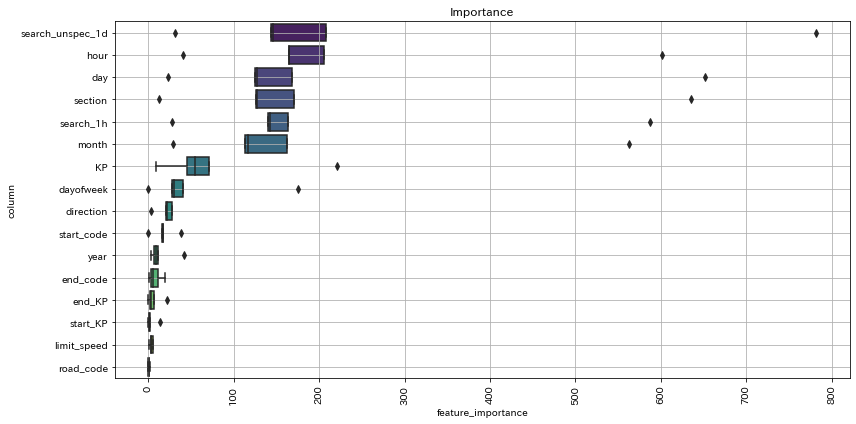

In [ ]:
# ========================================
# feature importance
# ========================================
def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        importance_type = 'split'
        _df["feature_importance"] = model.feature_importance(importance_type=importance_type)
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
    sns.boxplot(data=feature_importance_df,
                  x="feature_importance",
                  y="column",
                  order=order,
                  ax=ax,
                  palette="viridis",
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax, feature_importance_df

fig, ax, feature_importance_df = visualize_importance(models, train[feature_cols])

In [ ]:
# ========================================
# train-validation split
# ========================================
TARGET = 'is_congestion'
N_SPLIT = 5
kf = StratifiedGroupKFold(N_SPLIT)
cv_list = list(kf.split(train, y=train[TARGET], groups=train['date']))

# ========================================
# define variables
# ========================================
X = train[feature_cols]
y = train[TARGET]

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'is_unbalance': True, # 不均衡データを扱う
    'pos_weight': sum(y==0)/sum(y==1) # マイナークラスの重み付け
}

print('train shape:', train.shape)

# ========================================
# training
# ========================================
weight = None
score, oof_pred, models = train_lgbm(X, y=y, params=params, cv=cv_list, weight_dict=None)

train shape: (910080, 30)
Don't use sample weight.
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logloss: 0.131468	Train's f1: 0.136958	Valid's binary_logloss: 0.135903	Valid's f1: 0.113407
[200]	Train's binary_logloss: 0.0852303	Train's f1: 0.206448	Valid's binary_logloss: 0.0909644	Valid's f1: 0.158951
[300]	Train's binary_logloss: 0.063094	Train's f1: 0.264314	Valid's binary_logloss: 0.0684627	Valid's f1: 0.197309
[400]	Train's binary_logloss: 0.0496867	Train's f1: 0.317811	Valid's binary_logloss: 0.0558254	Valid's f1: 0.229876
[500]	Train's binary_logloss: 0.0408578	Train's f1: 0.365595	Valid's binary_logloss: 0.0476686	Valid's f1: 0.259113
[600]	Train's binary_logloss: 0.0343098	Train's f1: 0.408708	Valid's binary_logloss: 0.0416028	Valid's f1: 0.282717
[700]	Train's binary_logloss: 0.029195	Train's f1: 0.45096	Valid's binary_logloss: 0.0370076	Valid's f1: 0.303556
[800]	Train's binary_logloss: 0.0254038	Train's f1: 0.488518	Valid's binary_log

In [82]:

def train_lgbm(X, y, cv):
    
    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        train_date = x_train['date']
        #print(f'Train: {train_date.min()} >> {train_date.max()}')
        #print(x_train.shape)
        #print(y_train.value_counts())

        valid_date = x_valid['date']
        print(f'Validation: {valid_date.min()} >> {valid_date.max()}')
        #print(x_valid.shape)
        #print(y_valid.value_counts())

# ========================================
# train-validation split
# ========================================
TARGET = 'is_congestion'
N_SPLIT = 5
kf = StratifiedGroupKFold(N_SPLIT)
cv_list = list(kf.split(train, y=train[TARGET], groups=train['date']))

# ========================================
# define variables
# ========================================
X = train[feature_cols+['date']]
y = train[TARGET]

print(X.shape)
print(y.shape)

train_lgbm(X, y, cv_list)

(910080, 17)
(910080,)
Validation: 2021-04-08 00:00:00 >> 2022-07-29 00:00:00
Validation: 2021-04-09 00:00:00 >> 2022-07-31 00:00:00
Validation: 2021-04-10 00:00:00 >> 2022-07-27 00:00:00
Validation: 2021-04-13 00:00:00 >> 2022-07-30 00:00:00
Validation: 2021-04-11 00:00:00 >> 2022-07-14 00:00:00


In [84]:
X

,road_code,start_code,end_code,section,direction,dayofweek,year,month,day,hour,search_1h,search_unspec_1d,KP,start_KP,end_KP,limit_speed,date
0,1,0,11,0,1,3,2021,4,8,0,15.0,3448.0,3.900,0.0,9.4,100,2021-04-08
1,1,0,11,0,1,3,2021,4,8,1,6.0,3448.0,3.900,0.0,9.4,100,2021-04-08
2,1,0,11,0,1,3,2021,4,8,2,3.0,3448.0,3.900,0.0,9.4,100,2021-04-08
3,1,0,11,0,1,3,2021,4,8,3,26.0,3448.0,3.900,0.0,9.4,100,2021-04-08
4,1,0,11,0,1,3,2021,4,8,4,31.0,3448.0,3.900,0.0,9.4,100,2021-04-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910075,0,10,9,16,0,6,2022,7,31,19,0.0,119.0,83.025,87.2,79.7,100,2022-07-31
910076,0,10,9,16,0,6,2022,7,31,20,0.0,119.0,83.025,87.2,79.7,100,2022-07-31
910077,0,10,9,16,0,6,2022,7,31,21,0.0,119.0,83.025,87.2,79.7,100,2022-07-31
910078,0,10,9,16,0,6,2022,7,31,22,0.0,119.0,83.025,87.2,79.7,100,2022-07-31
